# Unser Finanzprojekt

Dieses Notebook enthält Datenbereinigung und Analysen zur Zeitreihe der Preisentwicklung des Deutschen Aktienindex DAX.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#read in csv data
df = pd.read_csv("GDAX_histdata.csv",)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
8722,2021-11-10,16053.000000,16076.559570,15985.900391,16067.830078,16067.830078,62124400.0
8723,2021-11-11,16067.339844,16114.549805,16032.500000,16083.110352,16083.110352,56626200.0
8724,2021-11-12,16100.080078,16122.759766,16065.059570,16094.070313,16094.070313,60302900.0
8725,2021-11-15,16109.410156,16149.870117,16072.290039,16148.639648,16148.639648,53296600.0
8726,2021-11-16,16174.309570,16266.259766,16157.580078,16247.860352,16247.860352,56783300.0


In [16]:
#general statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,8559.0,6.053019e+03,3.801706e+03,936.0,2540.349976,5.471700e+03,8.141850e+03,1.617431e+04
High,8559.0,6.094780e+03,3.823382e+03,936.0,2549.760010,5.523670e+03,8.193645e+03,1.626626e+04
Low,8559.0,6.006814e+03,3.777956e+03,936.0,2524.994996,5.419550e+03,8.097360e+03,1.615758e+04
Close,8559.0,6.052400e+03,3.801565e+03,936.0,2540.334961,5.468470e+03,8.125125e+03,1.624786e+04
Adj Close,8559.0,6.052400e+03,3.801565e+03,936.0,2540.334961,5.468470e+03,8.125125e+03,1.624786e+04
Volume,8559.0,6.814296e+07,6.434472e+07,0.0,0.000000,7.229720e+07,1.064260e+08,5.101956e+08


In [29]:
#check for holidays
df.loc[df["Close"].isna(),"Date"]

1       1987-12-31
2       1988-01-01
67      1988-04-01
68      1988-04-04
96      1988-05-12
           ...    
7232    2015-12-25
7598    2017-06-05
7684    2017-10-03
7704    2017-10-31
7842    2018-05-21
Name: Date, Length: 168, dtype: object

In [30]:
#drop rows for holidays (no data)?

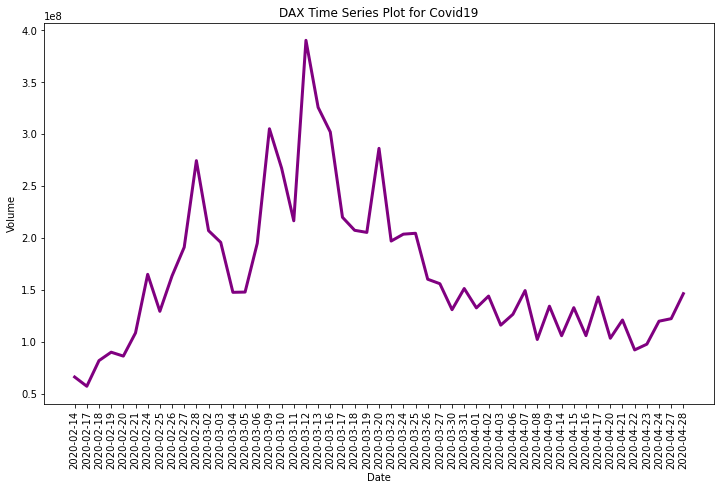

In [48]:
fig,ax = plt.subplots(figsize=[12,7])
sns.lineplot(x=df.loc[8280:8330,"Date"],
             y=df.loc[8280:8330,"Volume"],
             linewidth=3, color='purple',
             ).set(title='DAX Time Series Plot for Covid19');
plt.xticks(rotation=90);

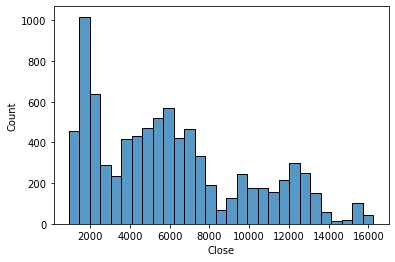

In [49]:
sns.histplot(df["Close"]);

In [50]:
df.loc[:,["Open","Close"]].corr()

,Open,Close
Open,1.000000,0.999815
Close,0.999815,1.000000
